
GPT-4o Classification Results:
Filename: Fetal Brain Abnormalities Ultrasound.v1i.multiclass/test/Copy-of-mild-ventriculomegaly-18c_aug_2_png_jpg.rf.1a7978b80bec239d05c1870f509b7aaa.jpg
True Label: mild ventriculomegaly
Predicted Label: mild ventriculomegaly
Analysis: The ultrasound image shows dilated lateral ventricles within the fetal brain. The enlargement is noticeable but not extreme, suggesting a classification of increased ventricular size.

Final Classification: Mild Ventriculomegaly
--------------------------------------------------------------------------------
Filename: Fetal Brain Abnormalities Ultrasound.v1i.multiclass/test/Copy-of-intracranial-hemorrdge-34a_aug_4_png_jpg.rf.28478dd858a77613009654fc5c607fe6.jpg
True Label: intracranial hemorrhage
Predicted Label: severe ventriculomegaly
Analysis: The ultrasound image shows a significant enlargement of the lateral ventricles of the fetal brain. The ventricles appear prominently dilated, which suggests an accumulation of c

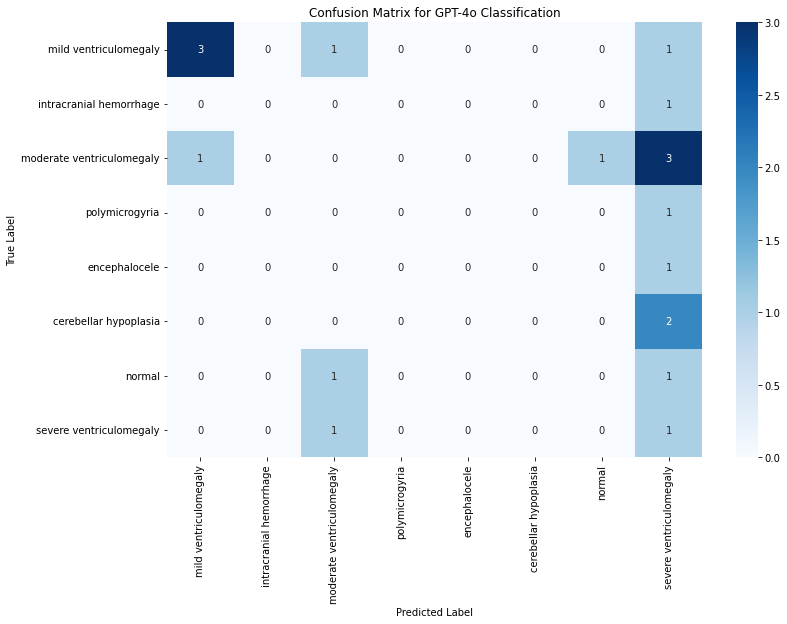

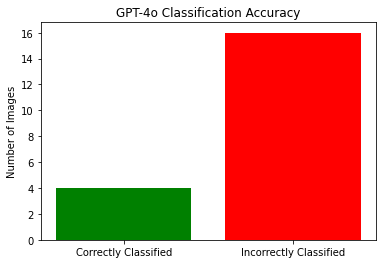

In [13]:
import openai
import base64
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# OpenAI API Key 
openai.api_key = "-"

# List of valid classification labels
VALID_CONDITIONS = [
    "arnold chiari malformation", "arachnoid cyst", "cerebellar hypoplasia", "colpocephaly", 
    "encephalocele", "holoprosencephaly", "hydranencephaly", "intracranial hemorrhage", 
    "intracranial tumor", "mega cisterna magna", "mild ventriculomegaly", "moderate ventriculomegaly", 
    "normal", "polymicrogyria", "severe ventriculomegaly", "vein of galen malformation"
]

def encode_image(image_path):
    """
    Convert an image to base64 encoding for OpenAI Vision API.
    """
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"File not found: {image_path}")
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

def analyze_ultrasound(image_path):
    """
    Analyzes a fetal brain ultrasound image with GPT-4o.
    Returns an analysis report including diagnostic insights.
    """
    try:
        image_base64 = encode_image(image_path)
        response = openai.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": (
                    "You are an AI specializing in pattern recognition in ultrasound images. "
                    "Analyze the given fetal brain ultrasound image and describe any notable visual patterns. "
                    "Match the image to one of the following categories: " + ", ".join(VALID_CONDITIONS) + ". "
                    "Provide your analysis first, and then at the very end, explicitly state the classification in this format:\n\n"
                    "Final Classification: [condition]\n\n"
                    "Do not provide medical advice or diagnostic opinions—only describe visual features and provide the classification."
                )},
                {"role": "user", "content": [
                    {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{image_base64}"}}
                ]}
            ],
            max_tokens=500
        )
        return response.choices[0].message.content  # Return full analysis and classification
    except Exception as e:
        print(f"Error calling GPT-4o API: {e}")
        return None

def extract_final_classification(analysis_report):
    """
    Extracts the final classification label from the last mention of 'Final Classification:' in the GPT-4o response.
    """
    if not analysis_report:
        return "unknown"

    # Convert report to lowercase and split into lines
    lines = analysis_report.strip().split("\n")

    # Iterate in reverse to find "Final Classification:" and extract the condition
    for line in reversed(lines):
        line = line.strip().lower()
        if "final classification:" in line:
            pred_label = line.split("final classification:")[-1].strip()

            # Remove unwanted punctuation but preserve spaces
            pred_label = re.sub(r"[^\w\s]", "", pred_label)

            # Ensure extracted label is valid
            if pred_label in VALID_CONDITIONS:
                return pred_label
            else:
                print(f"Warning: Extracted invalid classification: '{pred_label}'. Check GPT output format.")

    return "unknown"

def get_ground_truth(row):
    """
    Extract the ground truth label from the dataset, handling multiple labels.
    """
    labels = [col for col in row.index[1:] if row[col] == 1]
    return labels[0] if len(labels) == 1 else "multiple" if labels else "unknown"

def evaluate_gpt4o(dataset_path):
    """
    Evaluates GPT-4o performance on a dataset of images with ground truth labels.
    """
    results = []
    
    # Load dataset (image filenames and one-hot encoded labels)
    dataset = pd.read_csv(dataset_path, encoding="utf-8", on_bad_lines='skip')
    dataset['ground_truth'] = dataset.apply(get_ground_truth, axis=1)
    
    # Process first 20 images for testing
    for _, row in dataset.head(20).iterrows():
        image_path = os.path.join("Fetal Brain Abnormalities Ultrasound.v1i.multiclass", "test", row['filename'])
        true_label = row['ground_truth']
        if os.path.exists(image_path):
            analysis_report = analyze_ultrasound(image_path)
            pred_label = extract_final_classification(analysis_report)
            results.append({"image": image_path, "true_label": true_label, "predicted_label": pred_label, "analysis": analysis_report})
        else:
            print(f"Skipping missing image: {image_path}")
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    results_df.to_csv("gpt4o_ultrasound_results.csv", index=False)
    
    # Display results
    print("\nGPT-4o Classification Results:")
    for _, row in results_df.iterrows():
        print(f"Filename: {row['image']}")
        print(f"True Label: {row['true_label']}")
        print(f"Predicted Label: {row['predicted_label']}")
        print(f"Analysis: {row['analysis']}")
        print("-" * 80)
    
    # Classification Report
    print("Classification Report:")
    y_true = results_df['true_label']
    y_pred = results_df['predicted_label']
    
    # Track "unknown" predictions
    unknown_count = (y_pred == "unknown").sum()
    print(f"Number of 'unknown' classifications: {unknown_count}")
    
    # Filter out unknown predictions for valid accuracy calculations
    y_true_filtered = y_true[y_pred != "unknown"]
    y_pred_filtered = y_pred[y_pred != "unknown"]
    
    if not y_true_filtered.empty and not y_pred_filtered.empty:
        print(classification_report(y_true, y_pred, labels=list(VALID_CONDITIONS), zero_division=1))
        print("Accuracy:", accuracy_score(y_true_filtered, y_pred_filtered))
    else:
        print("No valid classifications to report.")

    print("\nOverall Accuracy:", accuracy_score(y_true, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=y_true.unique())
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=y_true.unique(), yticklabels=y_true.unique())
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix for GPT-4o Classification")
    plt.show()

    # Bar Chart of Correct vs Incorrect Classifications
    correct_classifications = (y_true == y_pred).sum()
    incorrect_classifications = len(y_true) - correct_classifications
    
    plt.figure(figsize=(6, 4))
    plt.bar(["Correctly Classified", "Incorrectly Classified"], [correct_classifications, incorrect_classifications], color=['green', 'red'])
    plt.ylabel('Number of Images')
    plt.title('GPT-4o Classification Accuracy')
    plt.show()

# Example usage
dataset_path = os.path.join("Fetal Brain Abnormalities Ultrasound.v1i.multiclass", "test", "_classes - _classes.csv")
if os.path.exists(dataset_path):
    evaluate_gpt4o(dataset_path)
else:
    print("Dataset file not found! Ensure you provide a valid CSV.")
